## Import Library

In [42]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Embedding, TextVectorization, LSTM, Concatenate, Dropout, Normalization
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


## Variables

In [43]:
TEXT_COL = "ingredients_text"
NUM_COLS = [
    "energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "proteins_100g",
    "fiber_100g",
    "salt_100g",
    "sodium_100g"
]
LABEL_COL = "healthy_level"


## Import Dataset

In [44]:
df = pd.read_csv("./dataset/filtered_data.csv")

df = df.dropna(subset=[TEXT_COL] + NUM_COLS + [LABEL_COL])
df[LABEL_COL] = df[LABEL_COL].astype("category").cat.codes
num_classes = 3

## Split Dataset (Train Test)

In [45]:
X_text = df[TEXT_COL].astype(str).values
X_num = df[NUM_COLS].values
y = df[LABEL_COL].values   # should be int (0,1,2...) or categorical

# Train–test split
x_train_text, x_test_text, x_train_num, x_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

In [46]:
cat = df[LABEL_COL].astype("category")
print("Category order:", list(cat.cat.categories))

Category order: [0, 1, 2]


In [47]:
# TEXT VECTORIZATION
max_tokens = 20000
sequence_length = 200

text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length
)

# Adapt to training text
text_vectorizer.adapt(x_train_text)


In [48]:
# NORMALIZATION for numeric features
normalizer = Normalization()
normalizer.adapt(x_train_num)


## Model (Layers)

### String Data

In [49]:

text_input = Input(shape=(1,), dtype=tf.string, name="text_input")
x = text_vectorizer(text_input)
x = Embedding(max_tokens, 64)(x)
x = LSTM(64)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)


### Numeric Data

In [50]:
num_input = Input(shape=(len(NUM_COLS),), name="numeric_input")
n = normalizer(num_input)
n = Dense(64, activation="relu")(n)
n = Dropout(0.2)(n)


### Combined Data

In [51]:
combined = Concatenate()([x, n])
combined = Dense(64, activation="relu")(combined)
combined = Dropout(0.3)(combined)
# output = Dense(1, activation="sigmoid")(combined)
output = Dense(num_classes, activation="softmax")(combined)


model = Model(inputs=[text_input, num_input], outputs=output)


In [52]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 200)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 64)   │  1,280,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 9)         │         19 │ numeric_input[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │        640 │ normalization_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        195 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,326,294 (5.06 MB)

 Trainable params: 1,326,275 (5.06 MB)

 Non-trainable params: 19 (80.00 B)

## Training

In [53]:
history = model.fit(
    {"text_input": x_train_text, "numeric_input": x_train_num},
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32
)


Epoch 1/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.7574 - loss: 0.5714 - val_accuracy: 0.8063 - val_loss: 0.4458
Epoch 2/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.8217 - loss: 0.4274 - val_accuracy: 0.8423 - val_loss: 0.3758
Epoch 3/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.8418 - loss: 0.3849 - val_accuracy: 0.8690 - val_loss: 0.3465
Epoch 4/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.8559 - loss: 0.3590 - val_accuracy: 0.8726 - val_loss: 0.3335
Epoch 5/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.8629 - loss: 0.3431 - val_accuracy: 0.8792 - val_loss: 0.3189
Epoch 6/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.8668 - loss: 0.3315 - val_accuracy: 0.8724 - val_loss: 0.3207
Epoch 7/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.8717 - loss: 0.3232 - val_accuracy: 0.8814 - val_loss: 0.3038
Epoch 8/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 82s 96ms/step - accuracy: 0.8736 - loss: 0.3219 - 

## Evaluate

In [54]:
result = model.evaluate(
    {"text_input": x_test_text, "numeric_input": x_test_num},
    y_test
)


268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9027 - loss: 0.2507


## Plotting Result

In [55]:
import matplotlib.pyplot as plt

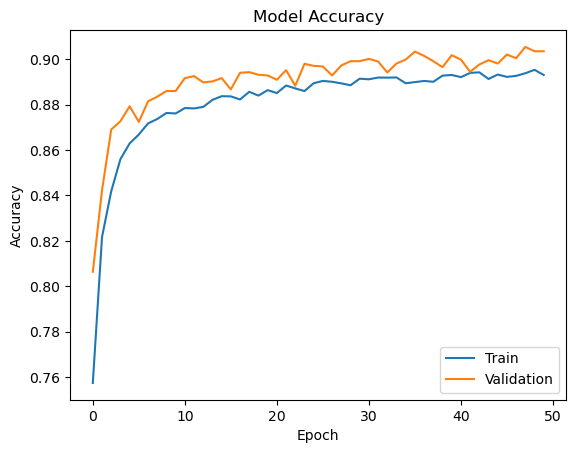

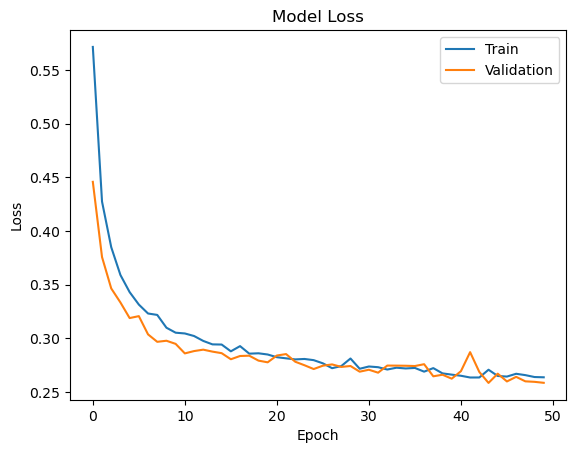

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()


## Save Model

In [57]:
model.save("./model/model.keras")

In [58]:
model_without_lookup = tf.keras.Model(
    inputs=model.input,
    outputs=model.output
)

model_without_lookup.save("./model/model_cleaned.keras")